In [41]:
import sys
import os
sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))    # So can access functions in isca_tools which is in home/Isca directory
import isca_tools
from metpy.calc import moist_static_energy, saturation_mixing_ratio, specific_humidity_from_mixing_ratio, parcel_profile, dewpoint_from_specific_humidity
import metpy.constants
from metpy.units import units
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [23]:
# Load dataset
exp_name = 'convective_coupling/aquaplanet/d5_sw_surface'
ds = isca_tools.load_dataset(exp_name)
namelist = isca_tools.load_namelist(exp_name)  # Need this for albedo_value
albedo = namelist['mixed_layer_nml']['albedo_value']
tau = namelist['two_stream_gray_rad_nml']['atm_abs']
p_full = namelist['spectral_dynamics_nml']['reference_sea_level_press']     # pressure of entire atmosphere in Pa
p_ref = 101325 # this is the default value of pstd_mks in the constants_nml of ISCA.
solar_exponent = 4  # this is the default value of solar_exponent in the grey radiation namelist.

## Spin up
The net flux converges, even if not exactly towards 0. I am still not sure if the $(1-\alpha \exp^{-\tau})$ prefactor is correct.
I use this prefactor because, on way from space to surface, shortwave radiation gets absorbed due to shortwave optical depth so
that the fraction of incoming that reaches the surface is $\exp^{-\tau}$.
A fraction $\alpha$ of this then gets reflected and returns to space.
[Isca](https://execlim.github.io/Isca/modules/two_stream_gray_rad.html#frierson-byrne-schemes) has no absorption of shortwave radiation of this upward reflected shortwave radiation.

## Using single surface pressure
The plot below shows the difference between shortwave flux absorbed at the surface as computed by Isca and saved as `swdn_sfc` in the dataset and that computed assuming a surface pressure as specified by `p_full`, taking into account the non-zero absorption by the atmosphere, as specified by `atm_abs`.

The fraction of incoming shortwave radiation that reaches the surface is $\exp^{-\tau}$.
A fraction $\alpha$ of this then gets reflected and returns to space.
Hence, $(1-\alpha \exp^{-\tau})$ prefactor.
Equation for shortwave optical depth for Frierson, as given by [Isca](https://execlim.github.io/Isca/modules/two_stream_gray_rad.html#frierson-byrne-schemes), is: $\tau = (\frac{p_s}{p_{ref}})^{\kappa}$

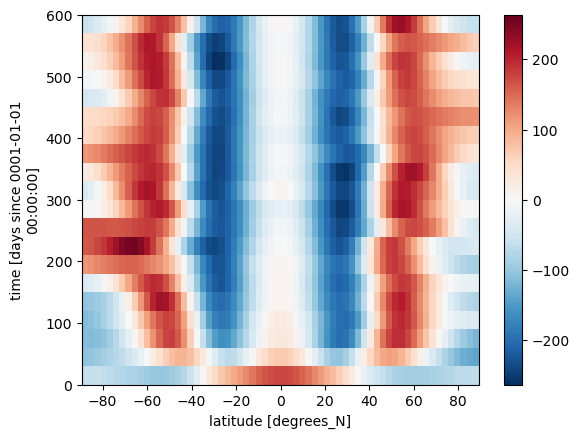

In [25]:
sw_surface_abs_isca = ds.swdn_sfc.sum(dim=['lon'])
p_surface = ds.ps.mean(dim=['lon'])
tau_surface = tau*(p_full/p_ref)**4
sw_surface_abs_manual = ((1-albedo) * np.exp(-tau_surface)) * ds.swdn_toa.sum(dim=['lon'])
(sw_surface_abs_isca-sw_surface_abs_manual).plot()

## Using actual surface pressure
Clearly, there is a difference between what is output by Isca and what I compute manually.
If instead, I use the actual surface pressure output by Isca instead of `p_full` everywhere, then the difference goes to 0 as shown below.

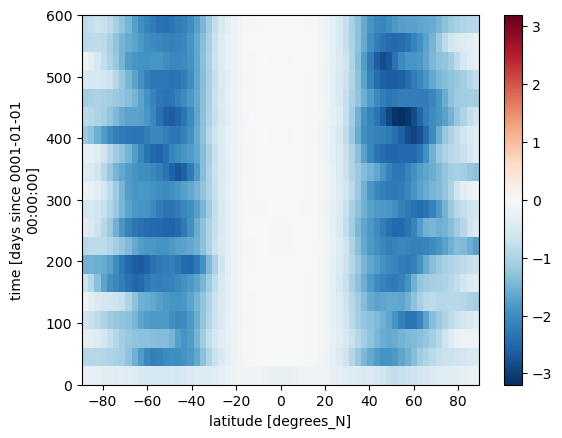

In [27]:
p_surface = ds.ps.mean(dim=['lon'])
tau_surface2 = tau*(p_surface/101325)**solar_exponent
sw_surface_abs_manual2 = ((1-albedo) * np.exp(-tau_surface2)) * ds.swdn_toa.sum(dim=['lon'])
(sw_surface_abs_isca-sw_surface_abs_manual2).plot()

## Spin up
Now comparing the spin up plots below, we see that using the actual surface pressure, we do get convergence closer to 0:


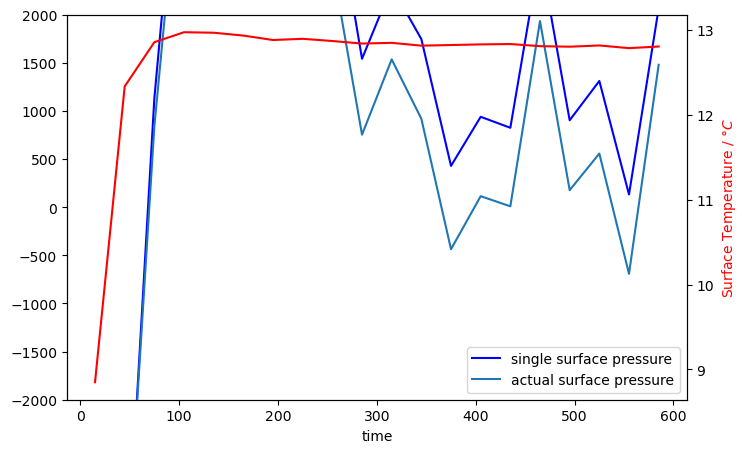

In [57]:
from isca_tools.utils import area_weighting
fig, ax = plt.subplots(1,1, figsize=(8, 5), sharex=True, sharey=True)
isca_tools.plot.plot_spin_up(ds.olr, ds.swdn_toa*(1-albedo*np.exp(-tau_surface)), ds.temp_2m, ax)
a = area_weighting(ds.olr).sum(dim=['lon','lat'])
b = (area_weighting(ds.swdn_toa).sum(dim='lon')*(1-albedo*np.exp(-tau_surface2))).sum(dim='lat')
(a-b).plot(ax=ax)
ax.set_ylim(-2000,2000);
ax.legend(['single surface pressure','actual surface pressure']);